In [143]:
# CONNECT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/dataset/covid19/text/news.csv")
df.tail(1)

,Unnamed: 0,authors,title,publish_date,description,text,url
6787,6786,[],N.S. municipality warns against annual Easter ...,2020-04-06 9:00,"In the midst of a pandemic, a Nova Scotia muni...","In the midst of a pandemic, a Nova Scotia muni...",https://www.cbc.ca/news/canada/nova-scotia/cla...


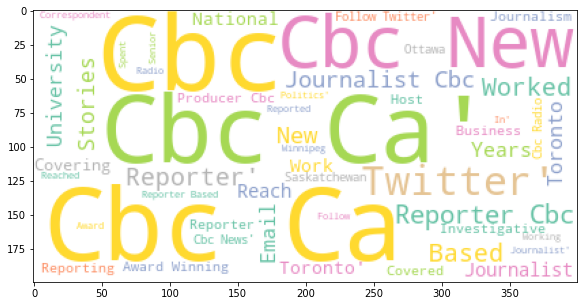

In [146]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

text = " ".join(str(author) for author in df.authors.unique() if len(author)>3)
wordcloud = WordCloud(max_words=50,colormap='Set2', background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.show()

In [159]:
df.tail(5)

,Unnamed: 0,authors,title,publish_date,description,text,url,token,token_bersih
6783,6782,['Cbc News'],Fishing industry in Windsor-Essex shut down du...,2020-04-06 10:49,Just as the yearly walleye run began in the De...,just as the yearly walleye run began in the de...,https://www.cbc.ca/news/canada/windsor/fishing...,"[just, as, the, yearly, walleye, run, began, i...","['yearly', 'walleye', 'run', 'began', 'detroit..."
6784,6783,['Cbc News'],Health Canada worker tests positive for COVID-19,2020-03-18 17:08,A Health Canada employee who works at Tunney's...,a health canada employee who works at tunney s...,https://www.cbc.ca/news/canada/ottawa/tunneys-...,"[a, health, canada, employee, who, works, at, ...","['health', 'canada', 'employee', 'works', 'tun..."
6785,6784,['Cbc News'],Taxis adapting to COVID-19 with plastic shield...,2020-04-19 11:30,Many in the taxi industry in St. John's though...,many in the taxi industry in st john s though...,https://www.cbc.ca/news/canada/newfoundland-la...,"[many, in, the, taxi, industry, in, st, john, ...","['many', 'taxi', 'industry', 'st', 'john', 'th..."
6786,6785,[],'An amazing man': Young father identified as n...,2020-03-31 12:55,The first person from northern Alberta to die ...,the first person from nohern albea to die of c...,https://www.cbc.ca/news/canada/edmonton/shawn-...,"[the, first, person, from, nohern, albea, to, ...","['first', 'person', 'nohern', 'albea', 'covid-..."
6787,6786,[],N.S. municipality warns against annual Easter ...,2020-04-06 9:00,"In the midst of a pandemic, a Nova Scotia muni...",in the midst of a pandemic a nova scotia muni...,https://www.cbc.ca/news/canada/nova-scotia/cla...,"[in, the, midst, of, a, pandemic, a, nova, sco...","['midst', 'pandemic', 'nova', 'scotia', 'munic..."


In [0]:
import string

def removePunctuation(strs):
    remove = string.punctuation
    remove = remove.replace("-", "") # don't remove hyphens
    remove = remove.replace("@", "") # don't remove hyphens
    remove = remove.replace("#", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern

    h = re.sub(pattern, " ", strs) 
    return h

def replace(strs):
    strs = strs.replace('\n','')
    strs = strs.replace('\t','')
    strs = strs.replace('rt','')
    return strs

def tokenize(strs):
    tokenizer = TweetTokenizer()
    nltk_tokens = tokenizer.tokenize(strs)
    return nltk_tokens

def removeAkunHastagsEmoji(tokens):
    regexp = re.compile(r'@[a-z]') #Hapus @
    filtered = filter(lambda i: not regexp.search(i), tokens)
    filtered = [i for i in tokens if not regexp.search(i)]
    regexp = re.compile(r'#[a-z0-9]') #Hapus #
    filtered = filter(lambda i: not regexp.search(i), filtered)
    filtered = [i for i in filtered if not regexp.search(i)]
    regexp = re.compile(r'[😂👏🙄👇🤣😅🙄🙈😀☝🙏👆😐👍🤔😊😉😌😊😉✌🤤😭😃🦄💪😔❤😑👉😆😁🙃💐⚡😎👌💯💃🎶👀☀💞😤👊✊😔🛀🙋👼👥😍✊😃💗👎🤦😁😞😡]') #Hapus Emoji
    filtered = filter(lambda i: not regexp.search(i), filtered)
    filtered = [i for i in filtered if not regexp.search(i)]
    return filtered

In [149]:
#PREPROCESSING
import nltk
nltk.download("punkt")
data = df
data['text'] = [i.lower() for i in df.description.astype(str)] #lowertext
data['text'] = [re.sub(r'http.*', '', i) for i in data.text] #remove link
data['text'] = [re.sub(r'<.*?>', '', i) for i in data.text] #remove html
data['text'] = [removePunctuation(i) for i in data.text] #remove punctuation
data['text'] = [replace(j) for j in data.text] #replace \n \t rt
data['token'] = [nltk.word_tokenize(i) for i in data.text] #tokenize string
data['token'] = [removeAkunHastagsEmoji(i) for i in data.token] #remove akun, hastags, emoji

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [150]:
data.tail(1)

,Unnamed: 0,authors,title,publish_date,description,text,url,token
6787,6786,[],N.S. municipality warns against annual Easter ...,2020-04-06 9:00,"In the midst of a pandemic, a Nova Scotia muni...",in the midst of a pandemic a nova scotia muni...,https://www.cbc.ca/news/canada/nova-scotia/cla...,"[in, the, midst, of, a, pandemic, a, nova, sco..."


In [151]:
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words())
def clean_stopwords(text):
    res = []
    for word in text:
        if word not in stopwords:
            res.append(word)
    return res

data['token_bersih'] = [clean_stopwords(i) for i in data.token]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [152]:
data.tail(1)

,Unnamed: 0,authors,title,publish_date,description,text,url,token,token_bersih
6787,6786,[],N.S. municipality warns against annual Easter ...,2020-04-06 9:00,"In the midst of a pandemic, a Nova Scotia muni...",in the midst of a pandemic a nova scotia muni...,https://www.cbc.ca/news/canada/nova-scotia/cla...,"[in, the, midst, of, a, pandemic, a, nova, sco...","[midst, pandemic, nova, scotia, municipality, ..."


In [0]:
#Stemming
ps = nltk.PorterStemmer()
data['token_bersih'] = [ps.stem(tmp) for tmp in data.token_bersih.astype(str)]

In [154]:
data.tail(1)

,Unnamed: 0,authors,title,publish_date,description,text,url,token,token_bersih
6787,6786,[],N.S. municipality warns against annual Easter ...,2020-04-06 9:00,"In the midst of a pandemic, a Nova Scotia muni...",in the midst of a pandemic a nova scotia muni...,https://www.cbc.ca/news/canada/nova-scotia/cla...,"[in, the, midst, of, a, pandemic, a, nova, sco...","['midst', 'pandemic', 'nova', 'scotia', 'munic..."


In [155]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
data_vektor = vectorizer.fit_transform(data['token_bersih'].fillna(' '))
data_vektor

<6788x10880 sparse matrix of type '<class 'numpy.int64'>'
	with 118702 stored elements in Compressed Sparse Row format>

In [156]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 7, random_state = 42)
lda.fit(data_vektor)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [157]:
data_vektor.shape

(6788, 10880)

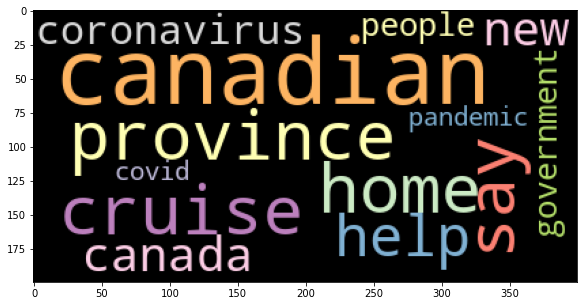

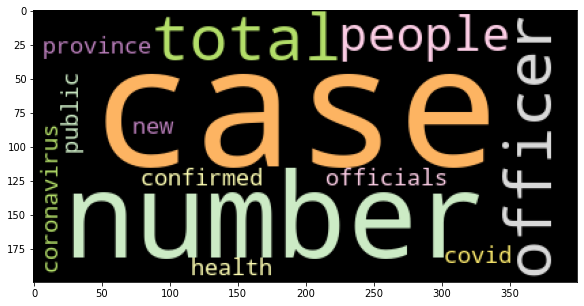

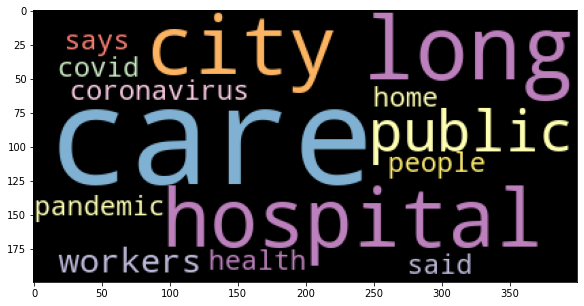

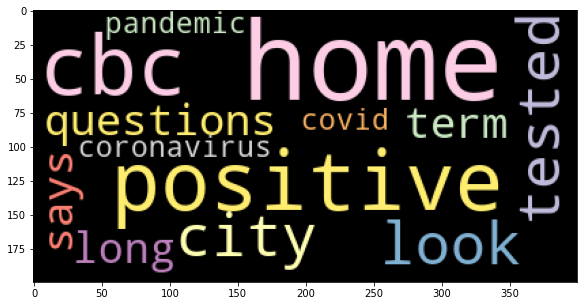

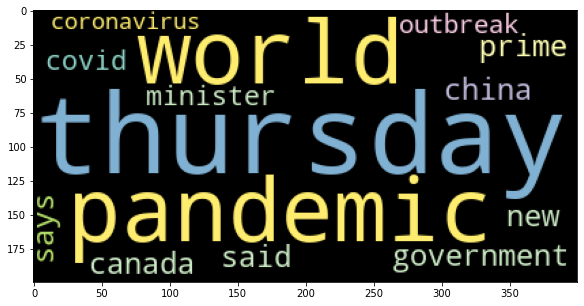

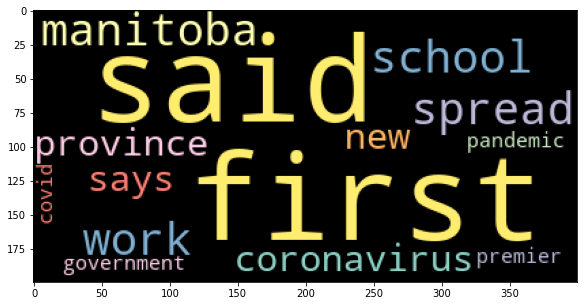

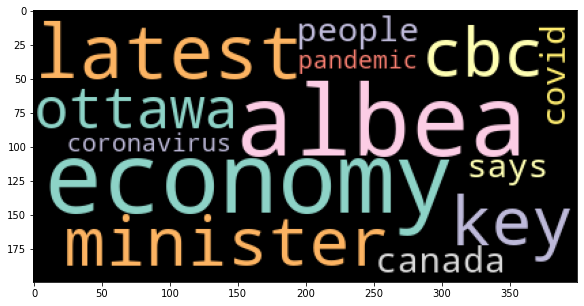

In [158]:
for index, topic in enumerate(lda.components_):
  tmps = [vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]]
  text = " ".join(str(topik) for topik in tmps)
  wordcloud = WordCloud(max_words=50,colormap='Set3', background_color="black").generate(text)
  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud)
  plt.show()